# Cargar Imagen

Cargamos la imagen que vamos a utilizar para la visualizacion.

Mounted at /content/drive


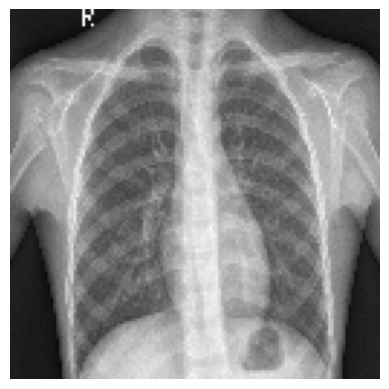

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
# Agregamos la dirección en la que se encuentran los datos 
drive.mount('/content/drive')
folder = '/content/drive/MyDrive/chest_xray'
image_shape = (128, 128)
test_image_path = folder + '/test/NORMAL/IM-0001-0001.jpeg'

def get_image_array(image_path):
  # Transformamos la imagen en un arreglo 
  img = load_img(image_path, target_size = image_shape )
  img_array = img_to_array(img)
  # Obtenemos la version de la imagen de la forma en nuestra 
  #red neuronal la procesa
  preprocess_img = preprocess_input(np.copy(img_array))
  # Para convertirlas a imagenes con batch_size = 1 agregamos una dimensión
  preprocess_img = np.expand_dims(preprocess_img, axis=0)
  img_array /= 255.0
  preprocess_img /= 255.0
  return img_array, preprocess_img

img_array, preprocess_img = get_image_array(test_image_path) 

plt.imshow(img_array)
plt.axis('off')
plt.show()

## Modelo Clase Anterior

Cargamos el modelo de la tarea anterior

In [ ]:
from keras.applications import ResNet50
from keras import models, layers
#Obtemos la ruta del modelo guardado en la tarea anterior 
model_route = folder + "best_model.h5"

retnet50 = ResNet50(
  weights='imagenet',
  include_top=False,
  input_shape=(*image_shape, 3)
)

model = models.Sequential()
model.add(retnet50) 
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

model.load_weights(model_route)

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                         

In [ ]:
retnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

# Grad-CAM

In [ ]:
import keras
import tensorflow as tf

# Funcion extraida y modificada de las notas del profesor.
def make_gradcam_heatmap(img_array, model, conv_layer_name, last_conv_layer_name, classifier_layer_names):
    
    # Modelo que mapea la imagen de entrada a la capa convolucional última,
    # donde se calculará la activación
    conv_layer       = model.get_layer(conv_layer_name)
    last_conv_layer  = conv_layer.get_layer(last_conv_layer_name)
    conv_model       = keras.Model(conv_layer.inputs, last_conv_layer.output)

    # Modelo que mapea las activaciones a la salida final
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Cálculo del gradiente la salida  del modelo clasificador respecto a     
    with tf.GradientTape() as tape:
        # Calcula activacion del modelo base convolucional
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Calcula la predicción con modelo clasificador, para la clase mas probable
        preds = classifier_model(last_conv_layer_output)
        top_class_channel = preds[0]
        print(top_class_channel)

    # Obtenemos el gradiente en la capa final clasificadora con respecto a
    # la salida del modelo base convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vector de pesos: medias del gradiente por capas,
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # salida de la última capa convolucional
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    # saliencia es la respuesta promedio de la última capa convolucional
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    # Multiplicación de cada canal por el vector de pesos
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Heatmap: promedio de cada canal por su peso
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
    
    return grad_cam, saliency

In [ ]:
grad_cam, saliency = make_gradcam_heatmap(
  preprocess_img, 
  model,
  "resnet50",
  "conv5_block3_out", 
  ["flatten", "dense", "dense_1", "dense_2", "dense_3"]
)

tf.Tensor([0.11440399], shape=(1,), dtype=float32)


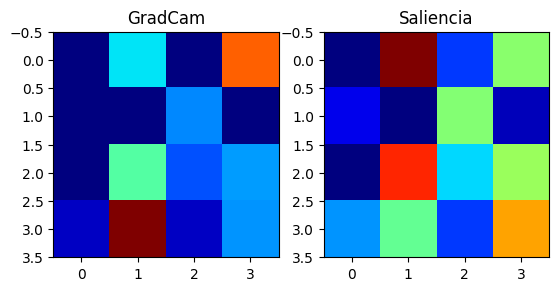

In [ ]:
plt.subplot(121)
plt.imshow(grad_cam, 'jet')
plt.title('GradCam')
plt.subplot(122)
plt.imshow(saliency, 'jet')
plt.title('Saliencia')
plt.show()

In [ ]:
from skimage.transform import resize

def show_hotmap (img, heatmap, title='Heatmap', alpha=0.5, cmap='jet', axisOnOff='off'):
  resized_heatmap=resize(heatmap, image_shape )
  
  fig, ax = plt.subplots()
  ax.imshow(img)
  ax.imshow(resized_heatmap, alpha=alpha, cmap=cmap)
  plt.axis(axisOnOff)
  plt.title(title)
  plt.show()

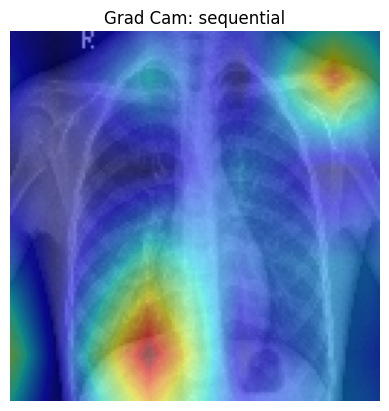

In [ ]:
show_hotmap(img=img_array, heatmap=grad_cam, title=f'Grad Cam: {model.name}')